In [51]:
import torch.nn as nn
import numpy as np
import gym
from seagul.rl.ars.meta_ars import MetaARSAgent
import matplotlib.pyplot as plt
import torch
import dill
import seagul.envs
import pybullet_envs
import pickle
from scipy.signal import find_peaks

from common import *
import os

%load_ext autoreload
%autoreload 2

from IPython.display import Audio
# sound_file = '/home/sgillen/Downloads/chime.wav'
# Audio(filename=sound_file, autoplay=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


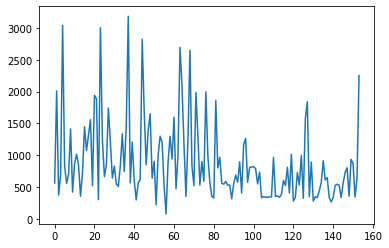

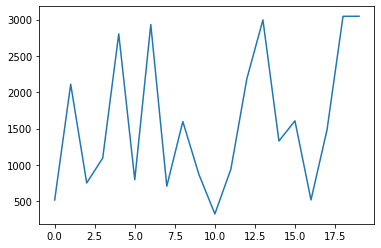

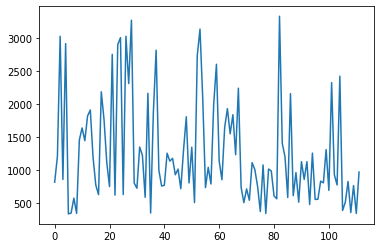

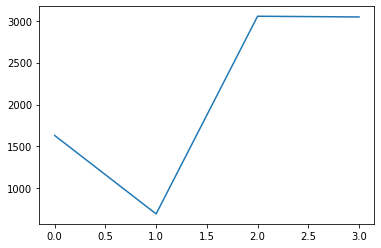

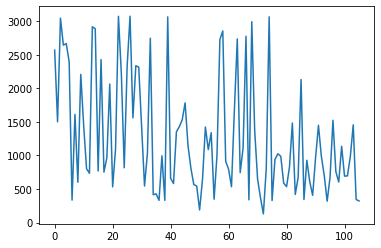

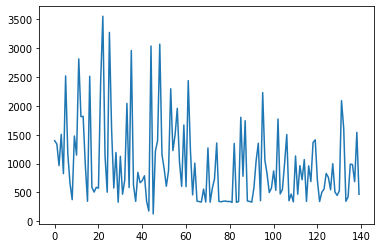

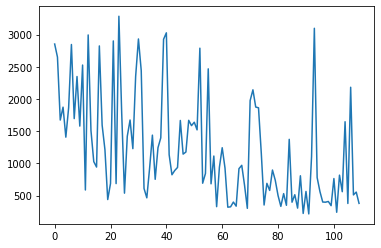

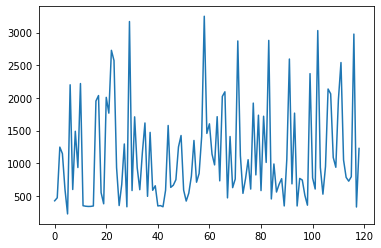

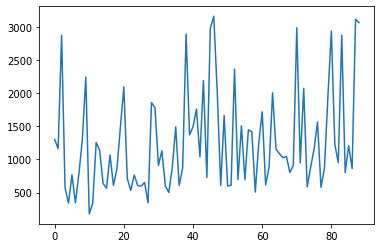

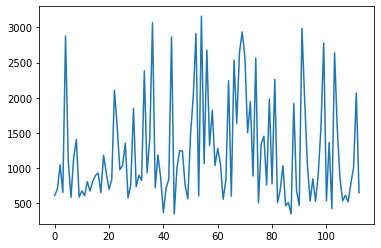

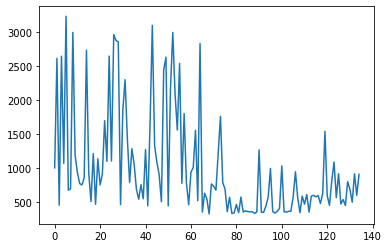

<Figure size 432x288 with 0 Axes>

In [13]:
agent_dir = "agents/sac/"
agent_list = [] 
import torch
for fileobj in os.scandir(agent_dir):
    var_dict = torch.load(open(f"{fileobj.path}", "rb"))
    agent_list.append(var_dict['self'])
    
#agent0 = meta_agent.agents[7]
#meta_agent = pickle.load(open("agents/meta_hurdl", "rb"))
for agent in agent_list:
    #agent0 = meta_agent.agents[7]
    plt.plot(agent.raw_rew_hist)
    plt.figure()

In [15]:
agent0 = agent_list[1]

[ 1.24830054e+00 -2.39478376e-04  3.74489709e-03  4.46832976e-03
 -3.13331619e-03  7.12183020e-04 -4.92190757e-03  2.64347674e-03
 -7.49090541e-04 -3.91345295e-03 -2.64938435e-03  0.00000000e+00]
tensor([1302.8307])


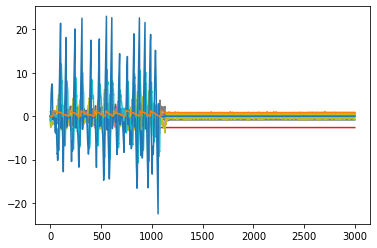

In [42]:
import time
def do_rollout_torch(env, agent,render=False, ep_length=2000, return_on_done=False):
    torch.autograd.set_grad_enabled(False)
    acts_list = []
    obs1_list = []
    obs2_list = []
    rews_list = []
    done_list = []

    dtype = torch.float32
    act_size = env.action_space.shape[0]
    n_controllers = 2
    obs = env.reset()
    done = False
    cur_step = 0
    model = agent.model
    
    while cur_step < ep_length:
        
        if render:
            env.render()
            time.sleep(0.01)
            
        obs = torch.as_tensor(obs, dtype=dtype)
        obs1_list.append(obs.clone())

        noise = torch.randn(1, n_controllers)
        c_weights, _ = model.select_action(obs.reshape(1, -1), noise)

        model_outs = torch.stack(
            [torch.tensor(m.step(obs.squeeze().numpy())[0], requires_grad=False, dtype=torch.float32) for m in agent.model.model_list]
        )

        act = torch.mm(c_weights.reshape(1,-1), model_outs)

        obs, rew, done, _ = env.step(act.numpy().reshape(-1))
        obs = torch.as_tensor(obs, dtype=dtype)

        acts_list.append(torch.as_tensor(c_weights.clone(), dtype=dtype))
        rews_list.append(torch.as_tensor(rew, dtype=dtype))
        obs2_list.append(obs.clone())

        if cur_step < ep_length:
            done_list.append(torch.as_tensor(done))
        else:
            done_list.append(torch.as_tensor(False))

        if done and return_on_done:
            break
        cur_step += 1

    ep_obs1 = torch.stack(obs1_list)
    ep_acts = torch.stack(acts_list).reshape(-1, n_controllers)
    ep_rews = torch.stack(rews_list).reshape(-1, 1)
    ep_obs2 = torch.stack(obs2_list)
    ep_done = torch.stack(done_list).reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs1, ep_obs2, ep_acts, ep_rews, ep_done



env_name = "hurdle_hopper-v0"
env = gym.make(env_name, gap_set = [30], hurdle_height=.52)

print(env.reset())
seed = 2
#env = gym.make("Hopper-v2")

#agent = meta_agent.agents[seed]
obs, obs2, act, rew, _  = do_rollout_torch(env, agent0, render=False, ep_length=3000)
print(sum(rew))
plt.plot(obs);

In [ ]:
# agent0.env_config={"slope_set":[0], 'random':False}
# agent0.postprocessor = mdim_div
# agent0.learn(100);
# Audio(filename=sound_file, autoplay=True)

In [ ]:
# import copy
# agent_list = []
# slope_set = [-.01, 0.0, .01]
# agent = copy.deepcopy(agent0)
# #agent.postprocessor = mdim_div
# agent.env_config = {"slope_set":[slope, 0.0]}
# agent.learn(200)
# agent_list.append(agent)
# Audio(filename=sound_file, autoplay=True)

In [ ]:
import copy
gap_lengths = [45]
#agent_list = []
for gap_length in gap_lengths:
    agent = copy.deepcopy(agent0)
    agent.n_workers = 8
    agent.step_schedule = [.05, .01]
    agent.exp_schedule  = [.05, .01]
    
    agent.postprocessor = mdim_div
    agent.env_config = {"gap_length":gap_length}
    agent.learn(500);    
    agent_list.append(copy.deepcopy(agent))  

0 : mean return: 595.5613020784681, fps:14636.824871570958
10 : mean return: 1029.6434274474545, fps:12914.888209667335
20 : mean return: 726.3151205336139, fps:13129.170925334085
30 : mean return: 1305.4823568608044, fps:12811.875313580738
40 : mean return: 561.7637854050525, fps:13533.491138072055
50 : mean return: 1364.9661613017297, fps:13861.334400556787
60 : mean return: 810.7215782727205, fps:14950.01614610128
70 : mean return: 1161.1668652105761, fps:16463.970050646145
80 : mean return: 1514.8756533469523, fps:15105.474495772685
90 : mean return: 1386.4026098980107, fps:15633.65624941727
100 : mean return: 1510.8299353875755, fps:14799.563804092351
110 : mean return: 1353.2521086224888, fps:17121.214157681687


In [ ]:
agent = copy.deepcopy(agent0)
agent.n_workers = 8
agent.env_config = {"gap_set":gap_lengths}
agent.learn(600);    
agent_list.append(copy.deepcopy(agent))

In [23]:
env_name = "hurdle_hopper-v0"
# seed = 4
# env = gym.make(env_name,slope_set=[0], random=True)
#env = gym.make("Hopper-v2")

env = gym.make(env_name,gap_set=[30])
#agent = meta_agent.agents[seed]
#env.unwrapped.gap_set = [20,30]
obs, act, rew, _ = do_rollout(env.unwrapped, agent_list[-2].model, render=True, ep_length=10000, return_on_done=True)
print(sum(rew))

plt.plot(obs);

Creating window glfw


KeyboardInterrupt: 

In [44]:
import xarray as xr
n_runs = 15
gap_lengths = [15,30]

data = xr.DataArray(np.zeros((len(gap_lengths), len(agent_list), n_runs)),
                    dims=("gap", "agent", "run"))

for i, gap_length in enumerate(gap_lengths):
    env.unwrapped.gap_length = gap_length 
    env.unwrapped.gap_set = None

    for j, agent in enumerate(agent_list):
        for run in range(n_runs):
            obs,obs2,act,rew,_= do_rollout_torch(env, agent, render=False, return_on_done=True)
            data.loc[i, j, run] = sum(rew).item()

In [45]:
print(data.mean(dim='run'))
print(data.std(dim='run'))

<xarray.DataArray (gap: 2, agent: 11)>
array([[ 441.25792033,  587.73062541,  589.79282633,  780.05393066,
         608.63515218,  750.89240723,  630.11283162,  543.84708049,
         619.38221436,  732.55501709,  409.70094198],
       [ 982.77865804,  811.24482015,  569.1317749 , 1203.34184163,
        1243.75974325, 1029.34513346, 1074.29261271, 1250.46279297,
        1361.11476847,  879.1228597 ,  779.57359416]])
Dimensions without coordinates: gap, agent
<xarray.DataArray (gap: 2, agent: 11)>
array([[127.04382618, 278.03966504, 170.16411909, 367.40342701,
        221.79049803, 453.92978885, 298.98479525, 186.97015121,
        186.62005567, 212.63176553, 149.33996977],
       [443.48947464, 561.76323403, 224.18839915, 709.09180446,
        796.17131643, 718.85740237, 585.45392693, 655.85193046,
        600.87022295, 408.15595978, 278.22302901]])
Dimensions without coordinates: gap, agent


In [49]:
import xarray as xr
n_runs = 15
gap_sets = ([30, 40], [30,45])

data = xr.DataArray(np.zeros((len(gap_sets), len(agent_list), n_runs)), dims=("gap", "agent", "run"))

for i, gap_set in enumerate(gap_sets):
    env.unwrapped.gap_length = None
    env.unwrapped.gap_set = gap_set

    for j, agent in enumerate(agent_list):
        for run in range(n_runs):
            obs,obs2,act,rew,_ = do_rollout_torch(env, agent, render=False, ep_length=2000, return_on_done=True)
            data.loc[i, j, run] = sum(rew).item()

In [50]:
print(data.mean(dim='run'))
print(data.std(dim='run'))

<xarray.DataArray (gap: 2, agent: 11)>
array([[1069.00065511, 1193.27322998,  690.44220581, 1169.06905518,
        1192.11846313,  949.3342509 , 1136.37975464,  906.49328308,
        1183.6538859 , 1067.21885986,  629.08596598],
       [ 985.7723348 , 1451.0553772 ,  542.06460775, 1410.25412191,
         738.47644043, 1003.47079061, 1125.93115641, 1242.11994629,
        1504.02378743, 1550.94018962,  691.41623128]])
Dimensions without coordinates: gap, agent
<xarray.DataArray (gap: 2, agent: 11)>
array([[571.13792824, 948.9299423 , 351.48587587, 618.30147461,
        639.43998911, 476.88361047, 819.75751736, 537.06478853,
        693.1091602 , 662.35622569, 120.03894357],
       [502.82632429, 825.29756351, 319.27891081, 818.77227898,
        669.58523702, 624.94200336, 570.47701902, 709.92944947,
        635.61508156, 765.7992833 , 298.83012884]])
Dimensions without coordinates: gap, agent


In [ ]:
#normal_seed  = 6
#noise_seed = 0 or 8

def my_reset(env, point):
    env.reset()
    reset_state = np.copy(point)
    reset_state[0] += (env.get_height(0) - env.model.hfield_size[0,2]/2)
    qpos = np.concatenate((np.array([0.0]), reset_state[:5]))
    qvel = reset_state[5:-1]
    env.unwrapped.set_state(qpos, qvel)
    return env.unwrapped._get_obs()

def fail_cond(env):
    
    s = env.unwrapped.state_vector()
    posafter, height, ang = env.unwrapped.sim.data.qpos[0:3]
    done = not (np.isfinite(s).all() and (np.abs(s[2:]) < 100).all() and
                    (height > .7) and (abs(ang) < .4))
    
    # set done = true if anything but the foot and ground are in contact.
    done = False
    ncon = env.unwrapped.sim.data.ncon
    for i in range(ncon):
        geom1 = env.unwrapped.sim.data.contact[i].geom1
        geom2 = env.unwrapped.sim.data.contact[i].geom2
        if not (geom1 == 4 or geom1 == 0):
            done = True
        if not (geom2 == 4 or geom2 == 0):
            done = True
            
    return done

#     #tilted = np.abs(ob[:,1]) > .2 
#     short = ob[:,0] < .7
#     #return np.logical_or(tilted, short)
#     return short

from common import *
from collections import namedtuple

class MeshBox:
    def __init__(self, state, iden, freq, npols):
        self.state = state
        self.id = iden
        self.freq = freq
        
        self.succ_list = [[] for _ in range(npols)]
        self.pred_list = []
        self.succ_rew_list =  [[] for _ in range(npols)]
            
        self.ttl = 0
        self.opt_controller = None
        
        
def do_push_rollout_from_state(env, policy, init_state, force, num_steps=200, force_steps = 0, render=False):
    act_list = []
    obs_list = []
    rew_list = []
    x_list = []
    obs = my_reset(env, init_state)

    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]

    for cur_step in range(num_steps):
        if render:
            env.render()
            time.sleep(.01)
        
        obs_list.append(np.copy(obs))

        x_list.append(env.unwrapped.sim.data.qpos[0])
        
        if cur_step < force_steps:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.array([force[0],0,force[1],0,0,0])
        else:
            env.unwrapped.sim.data.xfrc_applied[1,:] = np.zeros(6)
        
        act,_,_,_ = policy.step(obs)
        #act += torch.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
        
        act_list.append(np.copy(act))
        rew_list.append(rew)
        
        if done:
            break
        
    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list)
    ep_rew = ep_rew.reshape(-1, 1)

    return ep_obs, ep_act, ep_rew, None
        

In [ ]:
n_trials = 1000
import random
X_list = []
Y_list = []
for n in range(n_trials):
    obs_list = []; rew_list = []
    init_obs = env.reset()
    force = np.zeros(2)
    gap = random.choice(gap_lengths)
    env.unwrapped.gap_length = gap

    for agent in agent_list:
        obs, acts, rews, x = do_push_rollout_from_state(env, agent.model, init_obs, force, render=False)
        obs_list.append(obs)
        rew_list.append(sum(rews))
        
    winner = np.argmax(rew_list)
    [X_list.append(o) for o in obs_list[winner]]
    [Y_list.append(winner) for w in obs_list[winner]]
    
    

In [ ]:
X = np.array(X_list, dtype=np.float32)
Y = np.array(Y_list, dtype=np.long)

from seagul.nn import fit_model, MLP
net = MLP(12, 2, 2, 32, input_bias=True)

loss_hist = fit_model(net, X, Y, 25, batch_size=2048, loss_fn=torch.nn.CrossEntropyLoss(),use_tqdm=False)

plt.plot(loss_hist)

In [ ]:
#pols = [agent.model for agent in agent_list]
pols = [agent.model for agent in agent_list]
#npol.state_std[-1] = 1
npol = copy.deepcopy(pols[1])
def do_nn_rollout_from_state(env, pols, init_state, obs_std=0, act_std=0, num_steps=1000, render=True):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []
    val_list = []

    obs = my_reset(env, init_state)
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]
    pi = 0; old_pi = pi
    policy = pols[pi]

    while not done:
        if render:
            env.render()
            time.sleep(.01)
            
        n_obs = (obs - npol.state_mean)/npol.state_std
    
        preds = net(np.array(obs,dtype=np.float32))
        pi = torch.argmax(preds)
 
        if pi != old_pi:
           print(f"went from {old_pi} to {pi}")

        #print(env.get_height(0), env.get_height(1), env.get_height(2), obs[-1])
        old_pi = pi
        #policy = pols[pi]

        policy = pols[pi]

        obs += np.random.randn(obs_size)*obs_std
        obs_list.append(np.copy(obs))
        
        
        act,_,_,_ = policy.step(obs)
        act += np.random.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
                
        act_list.append(np.copy(act))
        rew_list.append(rew)
        
    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list).reshape(-1,1)
    ep_vals = np.array(val_list).reshape(-1,1)

    
    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_vals

#mesh_map = {state.id:state for state in mesh.values()}
#env.unwrapped.slope_set = [0.0]

env.unwrapped.gap_set = [100]
obs,act,rews,vals = do_nn_rollout_from_state(env, pols, env.reset(), render=False)

In [ ]:
plt.plot(obs);
sum(rews)

In [ ]:
delta =  .5;
#pols = #policy_dict[post_names[1]][0:3]
pols = [agent.model for agent in agent_list]
npol = copy.deepcopy(pols[1])
#npol.state_std[-1] = .01

mesh = BoxMesh(delta); mdim_l = []


fail_state = np.ones_like(env.reset())*100
fail_id = 0
mesh[fail_state] = MeshBox(fail_state, iden = 0, freq = 1, npols=len(pols))

for policy, gap in zip(pols, [100, 120]):
    print(policy,gap)
    #env = gym.make(env_name, gap_length=gap)
    env.unwrapped.gap_length = gap
    #env.reset()
    obs, acts, rews, uc_obs = do_rollout(env, policy, ep_length=1000, return_on_done=False, render=False)
    peak_idx,_ = find_peaks(obs[:,0], distance=50)


    for o in obs[peak_idx[2:],:]:
        key = (o - npol.state_mean)/npol.state_std

        if key in mesh:
            mesh[key].freq +=1
        else:
            mesh[key] =  MeshBox(o, iden = len(mesh), freq = 1, npols=len(pols))


    plt.plot(obs[:,0]);
    peak_idx,_ = find_peaks(obs[:,0], distance=20)

    for i in peak_idx[2:]:
        plt.axvline(x=i, color='r')

    print(fail_cond(env))

    print(f"{len(peak_idx[2:])} poincare snapshots, {len(mesh)} states in mesh")
    plt.figure();

In [ ]:
from multiprocessing import Pool
from itertools import repeat

slope_mesh = BoxMesh(.01)
slope_mesh[[.01]] = 1
slope_mesh[[0]] = 1
slope_mesh[[-.01]] = 1

In [ ]:
def do_explore_rollout(args):
    policy, init_state, trial_num = args
    slope = init_state[-1]
    force = np.zeros(2)
    env.seed(trial_num)
    env.unwrapped.slope_set = [slope]
    np.random.seed(trial_num)
    env.seed(trial_num)
    obs, acts, rews, x = do_push_rollout_from_state(env, policy, init_state, force, render=False)    
    
    return np.asarray(obs), np.asarray(rews)



start = time.time()
keys = list(mesh.keys())[1:]
i = 0 
slope_set = [-.01, 0, .01]
with Pool(12, maxtasksperchild=1000) as pool:
    for init_key in keys:    
        i+=1 
        
        init_state = mesh[init_key].state
        init_id = mesh[init_key].id
        
        state_iter = repeat(init_state, len(pols))
        rollout_seed_iter = range(i*len(pols), i*len(pols)+len(pols))

        for j, res in enumerate(pool.imap(do_explore_rollout, zip(pols, state_iter, rollout_seed_iter))):
            obs, rews = res
    
            peak_idx,_ = find_peaks(obs[:,0], distance=20)
            

            if fail_cond(env) or not peak_idx.any():
                new_id = fail_id
                new_key = fail_state
                mesh[init_key].succ_list[j].append(new_id)
                mesh[init_key].succ_rew_list[j].append(0)
                mesh[new_key].pred_list.append(init_id)
                        
            elif(peak_idx.any()):
                peak_obs = obs[peak_idx[0],:]
                for slope in slope_set: 
                    peak_obs[-1] = slope
                    new_key = ((peak_obs - np.array(npol.state_mean))/np.array(npol.state_std)).squeeze()
                    if new_key in mesh:
                        new_id = mesh[new_key].id
                        mesh[new_key].freq += 1
                    else:
                        mesh[new_key] = MeshBox(np.copy(peak_obs), len(mesh), 1, npols=len(pols))
                        new_id = len(mesh)-1
                        keys.append(mesh.__keytransform__(new_key))
                        
                    mesh[init_key].succ_list[j].append(new_id)
                    mesh[init_key].succ_rew_list[j].append(sum(rews))
                    mesh[new_key].pred_list.append(init_id)
            else:
                print("how???")
           
                
        if i % 1000 == 0:
            print(f"i; {i}, mdim: {len(keys)}, ratio: {i/len(keys)}")
            #print(f"i; {i}, iden: {len(iden_mesh)}, mdim: {len(mdim_mesh)}, ratio: {len(mdim_mesh)/len(iden_mesh)}")
        
print(time.time() - start)

In [ ]:
print(mesh)

key = list(mesh.keys())[1]

mesh_map = {state.id:state for state in mesh.values()}
npols=3
heights = np.array([m.state[-1] for m in mesh_map.values()])
plt.hist(heights[1:],bins=3)

In [ ]:
# Recursive TTL

def V(mesh_id):
    mesh_state = mesh_map[mesh_id]
    
    if mesh_state.visited:
        #print(f"{mesh_id} limit cycle detected")
        mesh_state.ttl = float('inf')
        return float('inf')
        
    if (np.asarray(mesh_state.state) == fail_state).all():
        #print(f"{mesh_id} returning 0")
        return 0
    
    elif mesh_state.ttl == 0:
        #print(f"{mesh_id} descending into {mesh_state.succ_list}")
        mesh_state.visited = True
        succ_V_list = [[] for _ in range(npols)]
        inf_list = []
        
        for next_controller_id, controller_succ_list in enumerate(mesh_state.succ_list):
            for next_state_id in controller_succ_list:
                succ_V_list[next_controller_id].append(V(next_state_id))
                
#         for controller_id, rew_list in next_list:
#             limit_idx = [i for i,ttl in enumerate(rew_list) if ttl == float('inf')]
#             if len(limit_idx):
#                 mesh_state.ttl = float('inf')
#                 limit_rewards = [mesh_state.succ_rew_list[i] for i in limit_idx]
#                 mesh_state.opt_controller = mesh_state.succ_rew_list.index(max(limit_rewards))

        else:
            min_slope_V = [min(thing) for thing in succ_V_list]
            max_controller_V = max(min_slope_V)
            curr_r  = max(max(mesh_state.succ_rew_list))
            
            mesh_state.ttl =  curr_r + max_controller_V
            mesh_state.opt_controller = min_slope_V.index(max_controller_V)

        #print(f"{mesh_id} resulting list was {next_list} , new ttl is {mesh_state.ttl}")
        return mesh_state.ttl
        
    else:
        #print(f"{mesh_id} returning ttl of {mesh_state.ttl}")
        return mesh_state.ttl
    
    
# Iterative TTL   
        
for state in mesh.values():
    state.ttl = 0
    state.visited = False
    
    
V(10)

In [ ]:
def do_opt_rollout_from_state(env, pols, init_state, obs_std=0, act_std=0, num_steps=1000, render=True):
    act_list = []
    obs_list = []
    rew_list = []
    val_list = []

    obs = my_reset(env, init_state)
    uc_obs = np.concatenate([env.sim.data.qpos.flat[1:], env.sim.data.qvel.flat])
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]
    pi = 1
    policy = pols[pi]


    
    out = 0
    inm = 0
    while not done:
        if render:
            env.render()
            time.sleep(.01)
            
        obs_key = (obs - npol.state_mean)/npol.state_std
        if not obs_key in mesh:
            out+=1
        else:
            if mesh[obs_key].opt_controller is None:
                V(mesh[obs_key].id)
            
            inm +=1
            print(mesh[obs_key].opt_controller)
            policy = pols[mesh[obs_key].opt_controller] 
            print(f"going from pol {pi} to {mesh[obs_key].opt_controller}" )
            pi = mesh[obs_key].opt_controller
            

        #policy = pols[0]

        obs += np.random.randn(obs_size)*obs_std
        obs_list.append(np.copy(obs))
        
       
        try:
            val_list.append(V(mesh[obs_key].id))
        except:
            pass
        
        act,_,_,_ = policy.step(obs)
        act += np.random.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
        
        act_list.append(np.copy(act))
        rew_list.append(rew)
        
    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list).reshape(-1,1)
    ep_vals = np.array(val_list).reshape(-1,1)

    
    print(out, inm)
    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_vals

#mesh_map = {state.id:state for state in mesh.values()}

env.unwrapped.slope_set = [0.0]#[0.00, 0.01, -0.01]
env.unwrapped.random=True
obs,act,rews,vals = do_opt_rollout_from_state(env, pols, mesh_map[10].state, render=True)

In [ ]:
num_trials = 250000
X = [(point.state - npol.state_mean)/npol.state_std for point in mesh_map.values()]
X = np.array(X, dtype=np.float32)

Yl = []
for x in X:
    if x[-1] < 0:
        Yl.append(0)
    elif x[-1] == 0:
        Yl.append(1)
    elif  x[-1] >  0:
        Yl.append(2)
    else:
        panic
        
    

Y = np.stack(Yl)
Y = np.array(Y,dtype=np.long)

In [ ]:
from seagul.nn import fit_model
net = MLP(12, 3, 2, 32)
loss_hist = fit_model(net, X, Y, 100, batch_size=2048, loss_fn=torch.nn.CrossEntropyLoss())

plt.plot(loss_hist)

In [ ]:
print(mesh_map[5].state)
net(np.array((mesh_map[1].state - npol.state_mean)/npol.state_std, dtype=np.float32))

In [ ]:
mesh_map[1].state

In [ ]:
def do_nn_rollout_from_state(env, pols, init_state, obs_std=0, act_std=0, num_steps=1000, render=True):
    act_list = []
    obs_list = []
    rew_list = []
    val_list = []

    obs = my_reset(env, init_state)
    uc_obs = np.concatenate([env.sim.data.qpos.flat[1:], env.sim.data.qvel.flat])
    done = False
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.shape[0]
    pi = 1; old_pi = pi
    policy = pols[pi]

    while not done:
        if render:
            env.render()
            time.sleep(.01)
    
        preds = net(np.array(obs,dtype=np.float32))
        pi = torch.argmax(preds)
        
#         if pi != old_pi:
#             print(f"went from {old_pi} to {pi}")

        #print(env.get_height(0), env.get_height(1), env.get_height(2), obs[-1])
        old_pi = pi
        policy = pols[pi]

        #policy = pols[0]

        obs += np.random.randn(obs_size)*obs_std
        obs_list.append(np.copy(obs))
        
        try:
            val_list.append(V(mesh[obs_key].id))
        except:
            pass
        
        act,_,_,_ = policy.step(obs)
        act += np.random.randn(act_size)*act_std
        obs, rew, done, _ = env.step(act)
        
        act_list.append(np.copy(act))
        rew_list.append(rew)
        
    ep_obs = np.stack(obs_list)
    ep_act = np.stack(act_list)
    ep_rew = np.array(rew_list).reshape(-1,1)
    ep_vals = np.array(val_list).reshape(-1,1)

    
    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_vals

#mesh_map = {state.id:state for state in mesh.values()}

env.unwrapped.slope_set = [0.01]
env.unwrapped.random=False
obs,act,rews,vals = do_nn_rollout_from_state(env, pols, mesh_map[10].state, render=True)

In [ ]:
plt.plot(obs[:,-1])

In [ ]:
torch.argmax??

In [ ]:
t = pickle.load(open("./agents/hurdle_100120_2", 'rb'))
t[0]

Creating window glfw
[581.82631353]


Text(0.5, 1.0, 'With reward postprocessing')

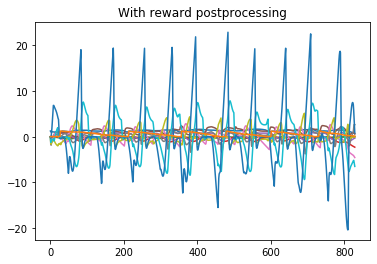

In [32]:
env_name = "hurdle_hopper-v0"
env = gym.make(env_name,gap_set=[30])

obs, act, rew, _ = do_rollout(env.unwrapped, agent_list[1].model, render=True, ep_length=2000, return_on_done=True)
print(sum(rew))
plt.plot(obs);
plt.title("With reward postprocessing")

In [ ]:
env_name = "hurdle_hopper-v0"
env = gym.make(env_name,gap_set=[15])

obs, act, rew, _ = do_rollout(env.unwrapped, iden_agent.model, render=False, ep_length=2000, return_on_done=True)
print(sum(rew))
plt.plot(obs);
plt.title("Without reward postprocessing")

In [25]:
with open("./agents/mdim_30_gap", "wb") as f:
    pickle.dump(agent_list,f)